In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 11.4 MB/s eta 0:00:0000:01


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import optuna

import matplotlib.pyplot as plt


In [3]:
# define transformations for the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean and standard deviation for MNIST
])

# download the complete MNIST data set
full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 499kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.73MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.92MB/s]


In [4]:
# split the data set into training and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# create a test data set
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# determine the batch size
batch_size = 64

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Number of batches in train_loader: {len(train_loader)}")


Train set size: 48000
Validation set size: 12000
Test set size: 10000
Number of batches in train_loader: 750


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [6]:
model = Net()

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device) 
print(device)

cuda


### No regularization

In [8]:
# no regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 10

train_losses = []
train_accs = []

val_losses = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data.view(data.size(0), -1))
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        train_total += target.size(0)
        train_correct += predicted.eq(target).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * train_correct / train_total
    
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    # validation step
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data.view(data.size(0), -1))
            loss = criterion(output, target)
            val_loss += loss.item()
            _, predicted = output.max(1)
            val_total += target.size(0)
            val_correct += predicted.eq(target).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * val_correct / val_total
    
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    print('-' * 50)


Epoch [1/10]
Train Loss: 0.2191, Train Accuracy: 93.28%
Val Loss: 0.1311, Val Accuracy: 95.87%
--------------------------------------------------
Epoch [2/10]
Train Loss: 0.0955, Train Accuracy: 97.01%
Val Loss: 0.1070, Val Accuracy: 96.68%
--------------------------------------------------
Epoch [3/10]
Train Loss: 0.0663, Train Accuracy: 97.89%
Val Loss: 0.0842, Val Accuracy: 97.56%
--------------------------------------------------
Epoch [4/10]
Train Loss: 0.0505, Train Accuracy: 98.36%
Val Loss: 0.0953, Val Accuracy: 97.35%
--------------------------------------------------
Epoch [5/10]
Train Loss: 0.0413, Train Accuracy: 98.66%
Val Loss: 0.1019, Val Accuracy: 97.42%
--------------------------------------------------
Epoch [6/10]
Train Loss: 0.0353, Train Accuracy: 98.89%
Val Loss: 0.1006, Val Accuracy: 97.42%
--------------------------------------------------
Epoch [7/10]
Train Loss: 0.0317, Train Accuracy: 98.99%
Val Loss: 0.1149, Val Accuracy: 97.17%
-----------------------------

### Visualization

In [9]:
def visualize_training_history(train_losses, train_accs, val_losses, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
 
    plt.tight_layout()
    plt.show()



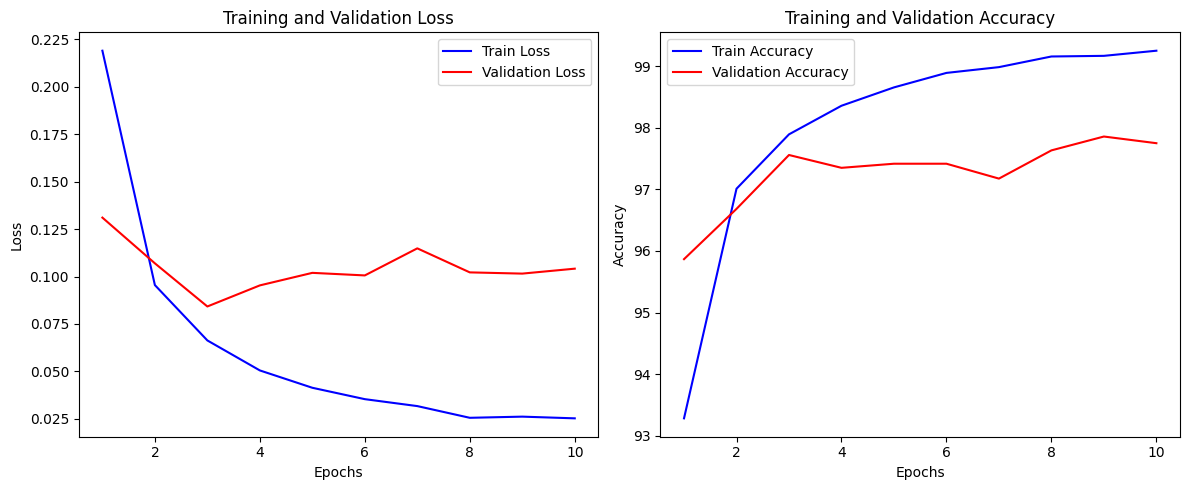

In [10]:
visualize_training_history(train_losses, train_accs, val_losses, val_accs)

### L2 regularization

Epoch [1/10]
Train Loss: 0.2296, Train Accuracy: 92.96%
Val Loss: 0.1476, Val Accuracy: 95.48%
--------------------------------------------------
Epoch [2/10]
Train Loss: 0.1163, Train Accuracy: 96.40%
Val Loss: 0.1059, Val Accuracy: 96.80%
--------------------------------------------------
Epoch [3/10]
Train Loss: 0.0938, Train Accuracy: 97.12%
Val Loss: 0.0985, Val Accuracy: 96.95%
--------------------------------------------------
Epoch [4/10]
Train Loss: 0.0813, Train Accuracy: 97.46%
Val Loss: 0.1007, Val Accuracy: 96.96%
--------------------------------------------------
Epoch [5/10]
Train Loss: 0.0742, Train Accuracy: 97.68%
Val Loss: 0.1005, Val Accuracy: 96.78%
--------------------------------------------------
Epoch [6/10]
Train Loss: 0.0705, Train Accuracy: 97.73%
Val Loss: 0.0872, Val Accuracy: 97.32%
--------------------------------------------------
Epoch [7/10]
Train Loss: 0.0661, Train Accuracy: 97.90%
Val Loss: 0.0946, Val Accuracy: 97.09%
-----------------------------

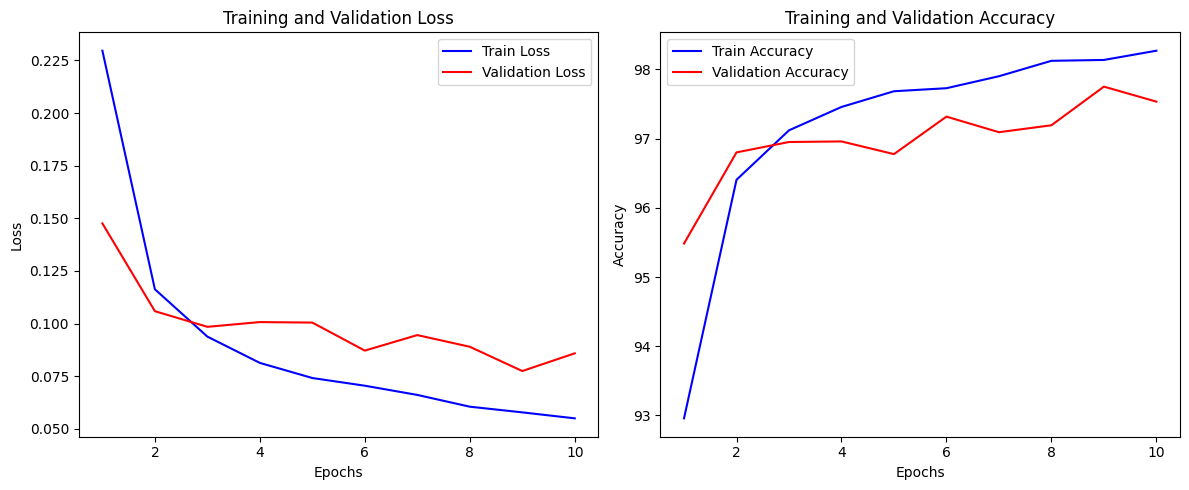

In [11]:
# L2 regularization

model = Net()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-3)

num_epochs = 10

train_losses = []
train_accs = []

val_losses = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data.view(data.size(0), -1))
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        train_total += target.size(0)
        train_correct += predicted.eq(target).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * train_correct / train_total
    
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    # validation step
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data.view(data.size(0), -1))
            loss = criterion(output, target)
            val_loss += loss.item()
            _, predicted = output.max(1)
            val_total += target.size(0)
            val_correct += predicted.eq(target).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * val_correct / val_total
    
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    print('-' * 50)
    
visualize_training_history(train_losses, train_accs, val_losses, val_accs)


### Early stopping

Epoch 0: Train Loss: 0.2190, Train Accuracy: 93.22%, Val Loss: 0.1223, Val Accuracy: 96.32%
Epoch 1: Train Loss: 0.0936, Train Accuracy: 97.05%, Val Loss: 0.1006, Val Accuracy: 97.15%
Epoch 2: Train Loss: 0.0655, Train Accuracy: 97.86%, Val Loss: 0.0912, Val Accuracy: 97.49%
Epoch 3: Train Loss: 0.0489, Train Accuracy: 98.45%, Val Loss: 0.0929, Val Accuracy: 97.53%
Epoch 4: Train Loss: 0.0400, Train Accuracy: 98.70%, Val Loss: 0.0920, Val Accuracy: 97.74%
Epoch 5: Train Loss: 0.0363, Train Accuracy: 98.84%, Val Loss: 0.0922, Val Accuracy: 97.63%
Early stopping triggered


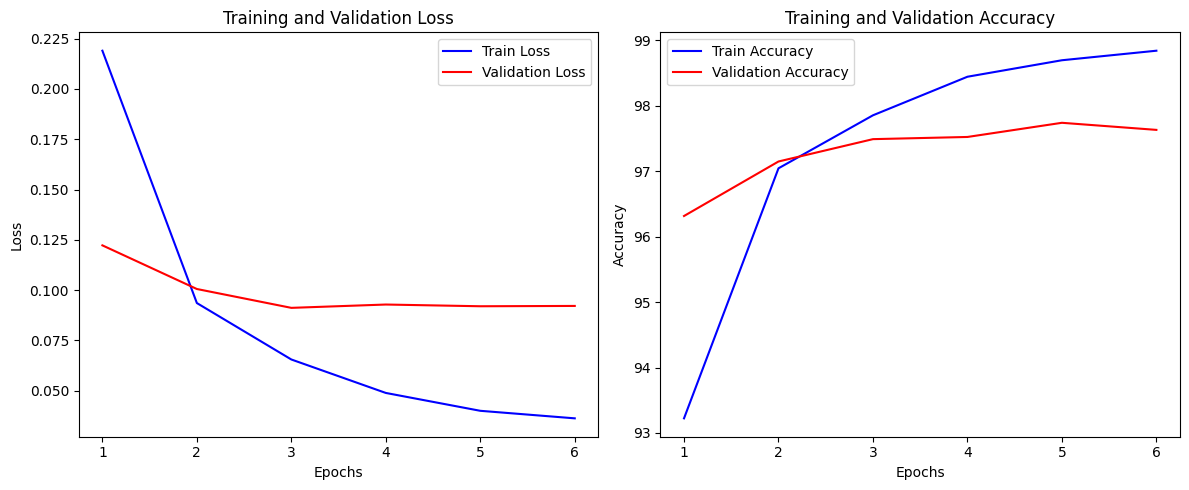

In [12]:
# early stopping

model = Net()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
best_val_loss = float('inf')
patience = 3    
counter = 0
num_epochs = 10

train_losses = []
train_accs = []

val_losses = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data.view(data.size(0), -1))
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        train_total += target.size(0)
        train_correct += predicted.eq(target).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * train_correct / train_total
    
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    # validation step
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data.view(data.size(0), -1))
            loss = criterion(output, target)
            val_loss += loss.item()
            _, predicted = output.max(1)
            val_total += target.size(0)
            val_correct += predicted.eq(target).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * val_correct / val_total
    
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break
visualize_training_history(train_losses, train_accs, val_losses, val_accs)

### Dropout

In [13]:
class NewWithDropout(nn.Module):
    def __init__(self):
        super(NewWithDropout, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)

Epoch [1/10]
Train Loss: 0.3476, Train Accuracy: 89.17%
Val Loss: 0.1445, Val Accuracy: 95.58%
--------------------------------------------------
Epoch [2/10]
Train Loss: 0.1963, Train Accuracy: 94.10%
Val Loss: 0.1070, Val Accuracy: 96.78%
--------------------------------------------------
Epoch [3/10]
Train Loss: 0.1639, Train Accuracy: 94.97%
Val Loss: 0.0996, Val Accuracy: 97.24%
--------------------------------------------------
Epoch [4/10]
Train Loss: 0.1489, Train Accuracy: 95.54%
Val Loss: 0.0939, Val Accuracy: 97.28%
--------------------------------------------------
Epoch [5/10]
Train Loss: 0.1353, Train Accuracy: 95.93%
Val Loss: 0.0911, Val Accuracy: 97.32%
--------------------------------------------------
Epoch [6/10]
Train Loss: 0.1302, Train Accuracy: 96.04%
Val Loss: 0.0854, Val Accuracy: 97.62%
--------------------------------------------------
Epoch [7/10]
Train Loss: 0.1265, Train Accuracy: 96.17%
Val Loss: 0.0865, Val Accuracy: 97.47%
-----------------------------

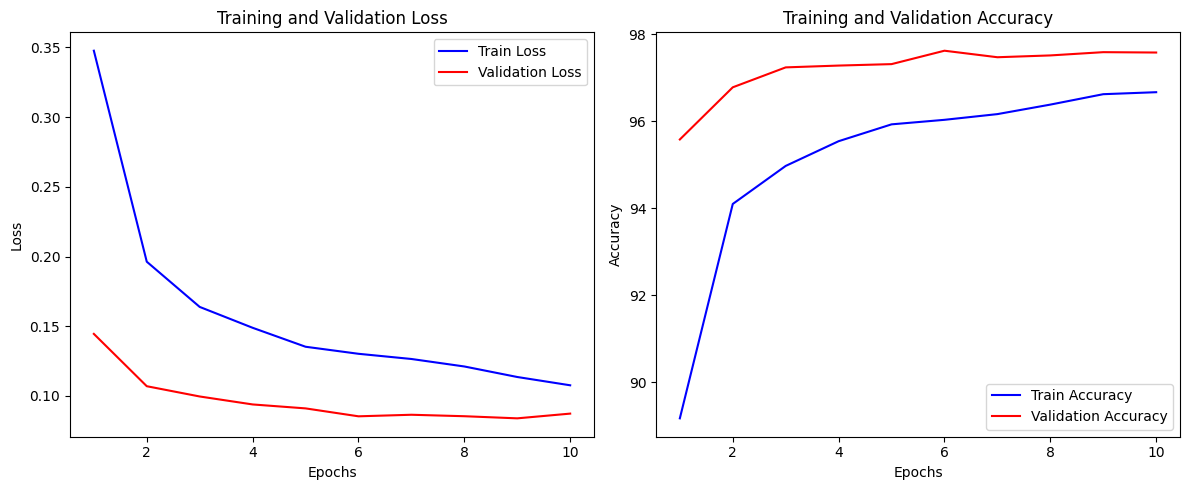

In [14]:
model = NewWithDropout()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 10

train_losses = []
train_accs = []

val_losses = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data.view(data.size(0), -1))
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        train_total += target.size(0)
        train_correct += predicted.eq(target).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * train_correct / train_total
    
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    # validation step
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data.view(data.size(0), -1))
            loss = criterion(output, target)
            val_loss += loss.item()
            _, predicted = output.max(1)
            val_total += target.size(0)
            val_correct += predicted.eq(target).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * val_correct / val_total
    
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    print('-' * 50)

visualize_training_history(train_losses, train_accs, val_losses, val_accs)


### Batch normalization

In [15]:
class NetWithBatchNorm(nn.Module):
    def __init__(self):
        super(NetWithBatchNorm, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        return self.fc3(x)

Epoch [1/10]
Train Loss: 0.2089, Train Accuracy: 93.78%
Val Loss: 0.0990, Val Accuracy: 97.08%
--------------------------------------------------
Epoch [2/10]
Train Loss: 0.0905, Train Accuracy: 97.19%
Val Loss: 0.0787, Val Accuracy: 97.61%
--------------------------------------------------
Epoch [3/10]
Train Loss: 0.0589, Train Accuracy: 98.14%
Val Loss: 0.0721, Val Accuracy: 97.80%
--------------------------------------------------
Epoch [4/10]
Train Loss: 0.0489, Train Accuracy: 98.43%
Val Loss: 0.0743, Val Accuracy: 97.78%
--------------------------------------------------
Epoch [5/10]
Train Loss: 0.0368, Train Accuracy: 98.78%
Val Loss: 0.0651, Val Accuracy: 98.09%
--------------------------------------------------
Epoch [6/10]
Train Loss: 0.0288, Train Accuracy: 99.02%
Val Loss: 0.0716, Val Accuracy: 98.08%
--------------------------------------------------
Epoch [7/10]
Train Loss: 0.0273, Train Accuracy: 99.05%
Val Loss: 0.0609, Val Accuracy: 98.34%
-----------------------------

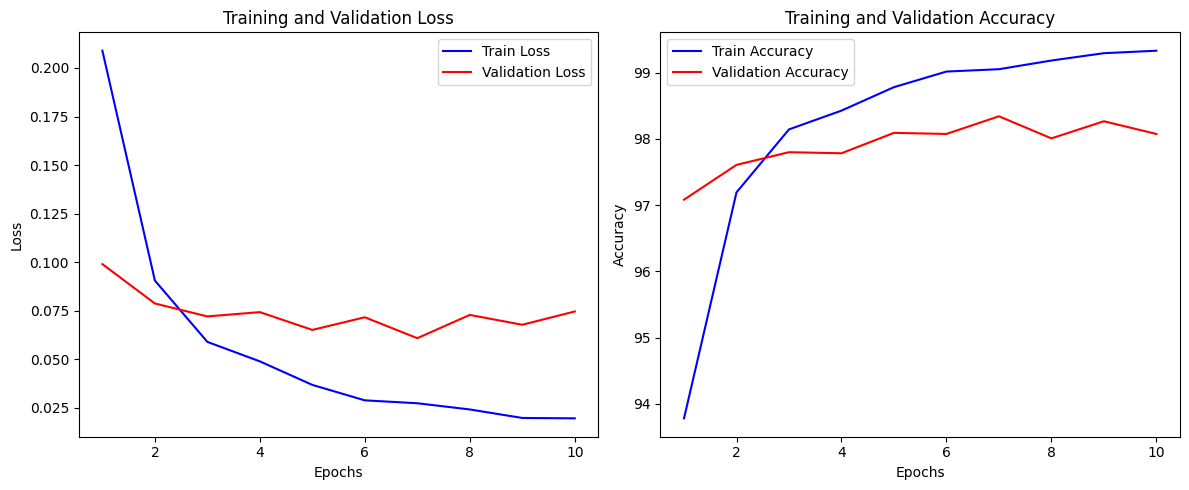

In [16]:
model = NetWithBatchNorm()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 10

train_losses = []
train_accs = []

val_losses = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data.view(data.size(0), -1))
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        train_total += target.size(0)
        train_correct += predicted.eq(target).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * train_correct / train_total
    
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    # validation step
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data.view(data.size(0), -1))
            loss = criterion(output, target)
            val_loss += loss.item()
            _, predicted = output.max(1)
            val_total += target.size(0)
            val_correct += predicted.eq(target).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * val_correct / val_total
    
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    print('-' * 50)

visualize_training_history(train_losses, train_accs, val_losses, val_accs)


### Optuna

In [17]:
class DynamicNet(nn.Module):
    def __init__(self, trial):
        super(DynamicNet, self).__init__()
        hidden_units = trial.suggest_int('n_units', 64, 512)
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
        self.fc1 = nn.Linear(784, hidden_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_units, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [18]:
def objective(trial):
    model = DynamicNet(trial)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    num_epochs = 10

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(data.view(data.size(0), -1))
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # validation step
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_loader):
                data = data.to(device)
                target = target.to(device)
                output = model(data.view(data.size(0), -1))
                _, predicted = output.max(1)
                val_total += target.size(0)
                val_correct += predicted.eq(target).sum().item()

        val_accuracy = 100. * val_correct / val_total
        trial.report(val_accuracy, epoch)

        if trial.should_prune():
            raise optuna.TrialPruned()

    return val_accuracy

In [19]:
# 1. Створюємо дослідження
# direction='maximize', тому що ми повертаємо accuracy (чим більше, тим краще)
# Якби повертали loss, було б 'minimize'
study = optuna.create_study(direction='maximize')

# 2. Запускаємо оптимізацію
# n_trials=20 означає, що Optuna спробує 20 різних варіантів Learning Rate
print("Починаємо пошук найкращих параметрів...")
study.optimize(objective, n_trials=20)

# 3. Дивимось результати
print("-" * 50)
print("Найкраща спроба:")
trial = study.best_trial

print(f"  Точність (Value): {trial.value:.2f}%")
print("  Параметри (Params): ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2026-01-21 08:28:33,647] A new study created in memory with name: no-name-d636314b-5a96-4acd-83d1-abf0b0934a6b


Починаємо пошук найкращих параметрів...


[I 2026-01-21 08:30:45,753] Trial 0 finished with value: 97.4 and parameters: {'n_units': 195, 'dropout_rate': 0.3157095022153361, 'lr': 0.0030651327132927867}. Best is trial 0 with value: 97.4.
[I 2026-01-21 08:32:58,231] Trial 1 finished with value: 97.7 and parameters: {'n_units': 437, 'dropout_rate': 0.36141712347778543, 'lr': 0.00017824325447338214}. Best is trial 1 with value: 97.7.
[I 2026-01-21 08:35:10,773] Trial 2 finished with value: 97.85833333333333 and parameters: {'n_units': 290, 'dropout_rate': 0.3085095566880013, 'lr': 0.0007397869493161407}. Best is trial 2 with value: 97.85833333333333.
[I 2026-01-21 08:37:24,533] Trial 3 finished with value: 89.95 and parameters: {'n_units': 72, 'dropout_rate': 0.36803218232916923, 'lr': 0.017520954204539044}. Best is trial 2 with value: 97.85833333333333.
[I 2026-01-21 08:39:37,358] Trial 4 finished with value: 85.20833333333333 and parameters: {'n_units': 489, 'dropout_rate': 0.36409700835714676, 'lr': 0.025012322530221752}. Best 

--------------------------------------------------
Найкраща спроба:
  Точність (Value): 98.00%
  Параметри (Params): 
    n_units: 285
    dropout_rate: 0.4690830188515157
    lr: 0.0006687337892126976


In [22]:
best_parametrs = study.best_params
print("Найкращі параметри збережені в змінній best_parametrs")
print(best_parametrs)

class UniversalNet(nn.Module):
    def __init__(self, trial=None, fixed_params=None):
        super(UniversalNet, self).__init__()
        if trial is not None:
            hidden_units = trial.suggest_int('n_units', 64, 512)
            dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
        elif fixed_params is not None:
            hidden_units = fixed_params['n_units']
            dropout_rate = fixed_params['dropout_rate']
        else:
            raise ValueError("Either trial or fixed_params must be provided")

        self.fc1 = nn.Linear(784, hidden_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_units, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

Найкращі параметри збережені в змінній best_parametrs
{'n_units': 285, 'dropout_rate': 0.4690830188515157, 'lr': 0.0006687337892126976}


Epoch [1/20]
Train Loss: 0.3486, Train Accuracy: 89.70%
Val Loss: 0.1714, Val Accuracy: 94.70%
--------------------------------------------------
Epoch [2/20]
Train Loss: 0.1808, Train Accuracy: 94.60%
Val Loss: 0.1167, Val Accuracy: 96.55%
--------------------------------------------------
Epoch [3/20]
Train Loss: 0.1404, Train Accuracy: 95.62%
Val Loss: 0.0997, Val Accuracy: 97.02%
--------------------------------------------------
Epoch [4/20]
Train Loss: 0.1208, Train Accuracy: 96.28%
Val Loss: 0.0936, Val Accuracy: 97.14%
--------------------------------------------------
Epoch [5/20]
Train Loss: 0.1068, Train Accuracy: 96.68%
Val Loss: 0.0834, Val Accuracy: 97.55%
--------------------------------------------------
Epoch [6/20]
Train Loss: 0.0950, Train Accuracy: 97.03%
Val Loss: 0.0783, Val Accuracy: 97.71%
--------------------------------------------------
Epoch [7/20]
Train Loss: 0.0866, Train Accuracy: 97.24%
Val Loss: 0.0774, Val Accuracy: 97.85%
-----------------------------

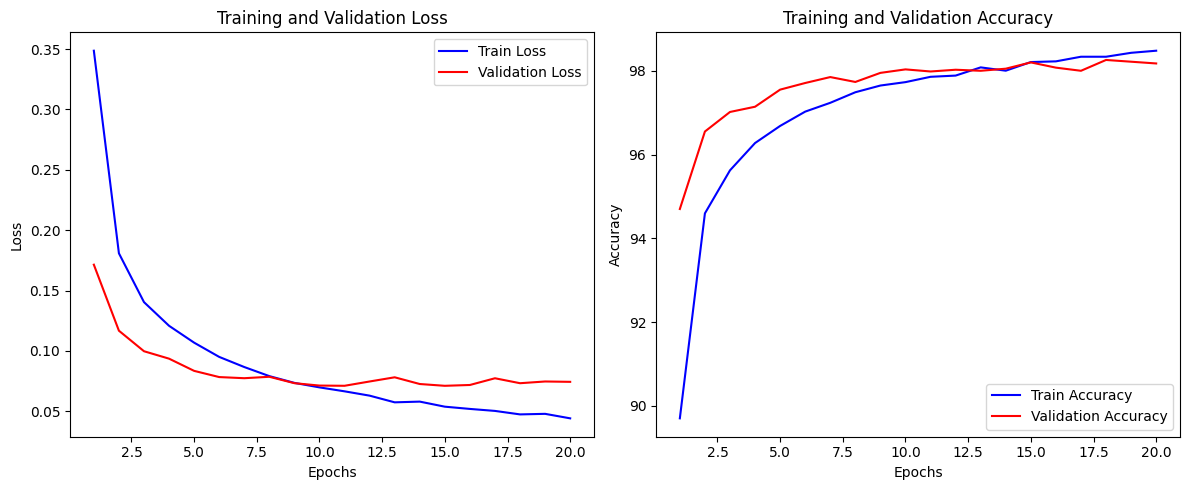

In [23]:
final_model = UniversalNet(fixed_params=best_parametrs)
final_model.to(device)

final_optimizer = optim.Adam(final_model.parameters(), lr=best_parametrs['lr'])
criterion = nn.CrossEntropyLoss()
num_epochs = 20

train_losses = []
train_accs = []

val_losses = []
val_accs = []

for epoch in range(num_epochs):
    final_model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        final_optimizer.zero_grad()
        output = final_model(data.view(data.size(0), -1))
        loss = criterion(output, target)
        loss.backward()
        final_optimizer.step()
        train_loss += loss.item()
        _, predicted = output.max(1)
        train_total += target.size(0)
        train_correct += predicted.eq(target).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * train_correct / train_total
    
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    # validation step
    final_model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            target = target.to(device)
            output = final_model(data.view(data.size(0), -1))
            loss = criterion(output, target)
            val_loss += loss.item()
            _, predicted = output.max(1)
            val_total += target.size(0)
            val_correct += predicted.eq(target).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * val_correct / val_total
    
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    print('-' * 50)

visualize_training_history(train_losses, train_accs, val_losses, val_accs)